### Terminologies

- Taken from [AI Wiki](https://machine-learning.paperspace.com/wiki/weights-and-biases)
- [Fast.ai](https://course.fast.ai/Lessons/lesson1.html)
- AWS Research Credits
- [QBlocks](https://www.qblocks.cloud)
- [Vast.ai](https://vast.ai)


#### Testing Neurons
Neurons are the basic units of a neural network. In an ANN, **each neuron in a layer is connected to some or all of the neurons in the next layer**. When the inputs are transmitted between neurons, the weights are applied to the inputs along with the bias.


#### Weights
Weights control the signal (or the strength of the connection) between two neurons. In other words, *a weight decides how much influence the input will have on the output.*

#### Overfitting

Overfitting is a condition where the model produces good performance when it’s applied to training samples. However, it results poorly when it is applied to unknown samples in the testing process. In other words, the model does not generalize well 
for the whole case. Overfitting  is a fundamental problem in the field of supervised machine 
learning that may occur because the model tends to learn the entire training data including noise, 
rather than learn patterns or important hidden information in the data 

## Downloading Dataset

### Celebrity Deepfakes Dataset

Taken from `gdown` docs

> I set the permission 'Anyone with Link', but I still can't download.
>> Google restricts access to a file when the download is concentrated. If you can still access to the file from your browser, downloading cookies file might help. Follow these steps:
>>>1) Download `cookies.txt` using browser extensions like (Get cookies.txt LOCALLY)
>>>
>>>2) mv the `cookies.txt` to `~/.cache/gdown/cookies.txt`
>>>
>>>3) run download again. If you're using gdown>=5.0.0, it should be able to use the cookies same as your browser.

In [16]:
# # !pip install gdown

# !cp /content/onedrive/cookies.txt  ~/.cache/gdown/cookies.txt

# !gdown 'https://drive.google.com/uc?id=1iLx76wsbi9itnkxSqz9BVBl4ZvnbIazj' --output /content/onedrive/dfd/datasets/CelebDF/v2.zip

# !unzip /content/onedrive/dfd/datasets/CelebDF/v2.zip -d /content/onedrive/dfd/datasets/CelebDF/

# !rm -rf /content/onedrive/dfd/datasets/CelebDF/v2.zip

## Model Training

### Imports

In [1]:
# File Processing
import os
import random
import shutil
from datetime import datetime

# Face extraction, cropping & display
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model Training
from __future__ import print_function
from itertools import chain
import csv
import random
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.transforms import ToPILImage
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import torchvision.transforms as transforms
import timm
from tabulate import tabulate

from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import dlib


Matplotlib is building the font cache; this may take a moment.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.version.cuda)

cuda
12.1


### Preprocessing

##### Directories Creation

In [14]:
# define base directory
real_videos = "E:/Deepscan-Repository/data/Videos/subset_400_400/celebdf_v2_fake"
fake_videos = "E:/Deepscan-Repository/data/Videos/subset_400_400/celebdf_v2_real"

now =  str(datetime.now()).replace(':', '_')
base_dir = f"E:/Deepscan-Repository/data/Frames/{now}"
os.mkdir(base_dir)

test_split_dirs = ['train', 'validation', 'test']
dirs = []

for dir in test_split_dirs:
    for subdir in ['_real_videos', '_real_frames', '_real_faces', '_fake_videos', '_fake_frames', '_fake_faces']:
        path = os.path.join(base_dir, dir + subdir)
        os.makedirs(path, exist_ok=True)
        dirs.append(path)

# Destructure the dirs list
(train_real_videos, train_real_frames, train_real_faces, train_fake_videos, train_fake_frames, train_fake_faces,
 validation_real_videos, validation_real_frames, validation_real_faces, validation_fake_videos, validation_fake_frames, validation_fake_faces,
 test_real_videos, test_real_frames, test_real_faces, test_fake_videos, test_fake_frames, test_fake_faces) = dirs


In [3]:
base_dir = "D:/Deepscan/working_data_with_48fps/"
train_real_faces = base_dir + 'train_real_faces'
train_fake_faces = base_dir + 'train_fake_faces'
validation_real_faces = base_dir + 'validation_real_faces'
validation_fake_faces = base_dir + 'validation_fake_faces'
test_real_faces = base_dir + 'test_real_faces'
test_fake_faces = base_dir + 'test_fake_faces'

##### Data Splitting

- Split the dataset into 60%, 20% & 20% for Training, Validation & Testing respectively.

    - train => 70% [70 fake% + 70 real%]
    - valid => 15% [15 fake% + 15 real%]
    - test => 15%  [15 fake% + 15 real%]

In [ ]:
def move_videos(real_videos_dir, fake_videos_dir, train_real_dir, train_fake_dir, validation_real_dir, validation_fake_dir, test_real_dir, test_fake_dir):
    # Get the list of real and fake videos
    real_videos = os.listdir(real_videos_dir)
    fake_videos = os.listdir(fake_videos_dir)

    # Calculate the number of videos for each split
    train_count_real = int (0.7 * len(real_videos))
    train_count_fake =int (0.7 * len(fake_videos))
    validation_count_real = int (0.15 * len(real_videos))
    validation_count_fake = int (0.15 * len(fake_videos))

    # Shuffle the videos for unbiased results
    for i in range(15):
        random.shuffle(real_videos)
        random.shuffle(fake_videos)

    # Move real videos
    for video in real_videos[:train_count_real]:
        print(f'Moving to Training Real Folder: {os.path.join(real_videos_dir, video)}')
        shutil.copy2(os.path.join(real_videos_dir, video), train_real_dir)
    for video in real_videos[train_count_real:train_count_real + validation_count_real]:
        print(f'Moving to Validation Real Folder: {os.path.join(real_videos_dir, video)}')
        shutil.copy2(os.path.join(real_videos_dir, video), validation_real_dir)
    for video in real_videos[train_count_real + validation_count_real:]:
        print(f'Moving to Testing Real Folder : {os.path.join(real_videos_dir, video)}')
        shutil.copy2(os.path.join(real_videos_dir, video), test_real_dir)

    # Move fake videos
    for video in fake_videos[:train_count_fake]:
        print(f'Moving to Training Fake Folder: {os.path.join(fake_videos_dir, video)}')
        shutil.copy2(os.path.join(fake_videos_dir, video), train_fake_dir)
    for video in fake_videos[train_count_fake:train_count_fake + validation_count_fake]:
        print(f'Moving to Validation Fake Folder: {os.path.join(fake_videos_dir, video)}')
        shutil.copy2(os.path.join(fake_videos_dir, video), validation_fake_dir)
    for video in fake_videos[train_count_fake + validation_count_fake:]:
        print(f'Moving to Testing Fake Folder: {os.path.join(fake_videos_dir, video)}')
        shutil.copy2(os.path.join(fake_videos_dir, video), test_fake_dir)

# Move real and fake videos
move_videos(real_videos, fake_videos,
            train_real_videos, train_fake_videos,
            validation_real_videos, validation_fake_videos,
            test_real_videos, test_fake_videos)


#### Videos Preprocessing

- In this code block, videos will be converted into frames and for 16 random frames, face will be cropped and extracted from the frame and will be stored as the preprocessed step.
- The face will be augmented, normalized & resized.


##### Frames Extraction

In [ ]:
# Function to extract frames from a video and select random frames
def extract_and_select_frames(video_path, output_dir, num_frames=8):
    video_cap = cv2.VideoCapture(video_path)
    total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Adjust num_frames if it's larger than the total number of frames
    num_frames = min(num_frames, total_frames)

    # Select random frames
    selected_frames = random.sample(range(0, total_frames), num_frames)

    # Read selected frames and save them
    for frame_number in selected_frames:
        video_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = video_cap.read()
        if not ret:
            continue
        cv2.imwrite(os.path.join(output_dir, f'{os.path.basename(video_path)}_frame_{frame_number}.jpg'), frame)
    video_cap.release()

# Process videos from the training set
for idx, video in enumerate(os.listdir(train_real_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Training Real Video {idx + 1}/{len(os.listdir(train_real_videos))}")
        extract_and_select_frames(os.path.join(train_real_videos, video), train_real_frames)

for idx, video in enumerate(os.listdir(train_fake_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Training Fake Video {idx + 1}/{len(os.listdir(train_fake_videos))}")
        extract_and_select_frames(os.path.join(train_fake_videos, video), train_fake_frames)

# Process videos from the validation set
for idx, video in enumerate(os.listdir(validation_real_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Validation Real Video {idx + 1}/{len(os.listdir(validation_real_videos))}")
        extract_and_select_frames(os.path.join(validation_real_videos, video), validation_real_frames)

for idx, video in enumerate(os.listdir(validation_fake_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Validation Fake Video {idx + 1}/{len(os.listdir(validation_fake_videos))}")
        extract_and_select_frames(os.path.join(validation_fake_videos, video), validation_fake_frames)

# Process videos from the testing set
for idx, video in enumerate(os.listdir(test_real_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Testing Real Video {idx + 1}/{len(os.listdir(test_real_videos))}")
        extract_and_select_frames(os.path.join(test_real_videos, video), test_real_frames)

for idx, video in enumerate(os.listdir(test_fake_videos)):
    if video.endswith('.mp4'):
        print(f"Processing Testing Fake Video {idx + 1}/{len(os.listdir(test_fake_videos))}")
        extract_and_select_frames(os.path.join(test_fake_videos, video), test_fake_frames)


##### Face Extraction using `dlib`

In [ ]:
def process_frame(frame_path, output_dir):
    # load the image
    print(f'Processing: {frame_path}')
    
    # Use Pillow to open the image
    with Image.open(frame_path) as img:
        # Convert the image to RGB if it's not already
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Convert PIL image to numpy array for dlib processing
        img_array = np.array(img)
    
    # Convert the image to grayscale for dlib processing
    gray_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    detector = dlib.get_frontal_face_detector()
    faces = detector(gray_array)
    
    for i, face in enumerate(faces):
        x = face.left()
        y = face.top()
        w = face.right() - x
        h = face.bottom() - y
        
        # Crop face region from the original RGB image using Pillow
        face_img = img.crop((x, y, x+w, y+h))
        
        # Save the cropped face in RGB format
        output_path = os.path.join(output_dir, f'{os.path.basename(frame_path)}_face_{i}.jpg')
        face_img.save(output_path)

def dlib_extract_faces(frame_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    frame_paths = [os.path.join(frame_dir, frame) for frame in os.listdir(frame_dir) if frame.endswith('.jpg')]
    
    for frame_path in frame_paths:
        process_frame(frame_path, output_dir)

dlib_extract_faces(train_real_frames, train_real_faces)
dlib_extract_faces(train_fake_frames, train_fake_faces)
dlib_extract_faces(validation_real_frames, validation_real_faces)
dlib_extract_faces(validation_fake_frames, validation_fake_faces)
dlib_extract_faces(test_real_frames, test_real_faces)
dlib_extract_faces(test_fake_frames, test_fake_faces)


#### Model Training

In [4]:
# Results Reproducibility
seed = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

##### Data Unification & Labeling

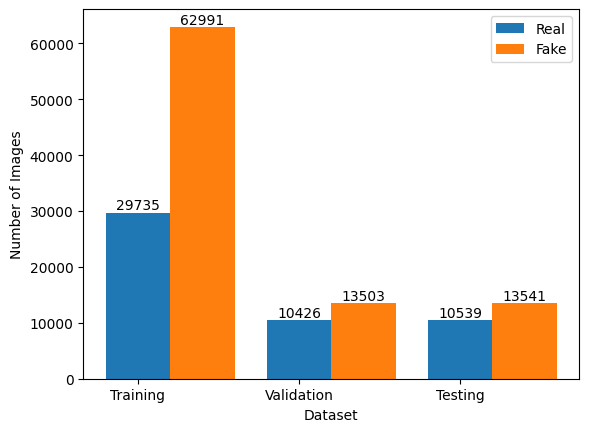

In [5]:
train_real_data = [os.path.join(train_real_faces, f) for f in os.listdir(train_real_faces)]
train_fake_data = [os.path.join(train_fake_faces, f) for f in os.listdir(train_fake_faces)]

validation_real_data = [os.path.join(validation_real_faces, f) for f in os.listdir(validation_real_faces)]
validation_fake_data = [os.path.join(validation_fake_faces, f) for f in os.listdir(validation_fake_faces)]

test_real_data = [os.path.join(test_real_faces, f) for f in os.listdir(test_real_faces)]
test_fake_data = [os.path.join(test_fake_faces, f) for f in os.listdir(test_fake_faces)]

# Create lists for real and fake images
train_data = [len(train_real_data), len(train_fake_data)]
validation_data = [len(validation_real_data), len(validation_fake_data)]
test_data = [len(test_real_data), len(test_fake_data)]

# Combine the data into a single list
data = [train_data, validation_data, test_data]

# Create labels for the plot
labels = ['Training', 'Validation', 'Testing']

# Create a bar chart
x = range(len(labels))
width = 0.4
plt.bar(x, [d[0] for d in data], width, label='Real')
plt.bar([x_i + width for x_i in x], [d[1] for d in data], width, label='Fake')

# Add labels and legend
plt.xticks(x, labels)
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.legend()

# Add the length of real and fake images on top of each bar
for i, d in enumerate(data):
    plt.text(i, d[0] + 1, f'{d[0]}', ha='center', va='bottom')
    plt.text(i + width, d[1] + 1, f'{d[1]}', ha='center', va='bottom')

# Show the plot
plt.show()

##### View Training Data

In [6]:
# Create lists for real and fake images
train_images = train_real_data + train_fake_data
validation_images = validation_real_data + validation_fake_data
test_images = test_real_data + test_fake_data

for i in range(15):
  np.random.shuffle(train_images)
  np.random.shuffle(validation_images)
  np.random.shuffle(test_images)

# print(train_images[:10])
# Extracting labels from directory paths
labels = []
for path in train_images:
    if 'real' in path:
        labels.append('real')
    else:
        labels.append('fake')

[92513 19502  3078 67233 47044 39929 34828 17418 78209]


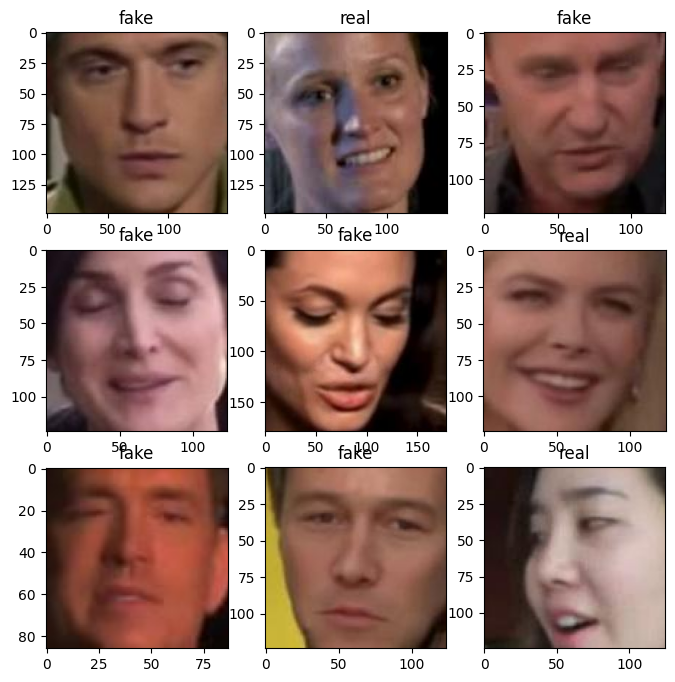

In [8]:
random_idx = np.random.randint(1, len(train_images), size=9)
print(random_idx)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for idx, ax in enumerate(axes.ravel()):
    # img = Image.open(all_training_images[idx])
    img = Image.open(train_images[random_idx[idx]])
    ax.set_title(labels[idx])
    ax.imshow(img)

##### Transform Compositions

- The code defines three separate transform compositions (`train_transforms`, `val_transforms`, and `test_transforms`) using PyTorch's Compose transform. Each composition includes:

    - Resizing the image to a fixed size of 224x224.
    - Randomly flipping the image horizontally with a probability of 0.5.
    - Converting the image to a PyTorch tensor.
      - Tensors are multi-dimensional arrays, similar to NumPy's ndarrays, but with the added capability of being able to run on GPUs.
    - Normalizing the tensor using the Normalize transform.
      - Normalization is a process of scaling the values of a tensor to a common range, typically between 0 and 1.


In [9]:
# from torchvision import datasets, transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [10]:
class DeepFakeSet(Dataset):
    def __init__(self, file_list, transform=None):

        self.file_list = file_list
        self.transform = transform
        self.to_img = ToPILImage()
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("Z:/Cuda+Torch+MKL-libs/shape_predictor_81_face_landmarks.dat")

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = 0 if 'real' in img_path else 1
        return img_transformed, label

In [13]:
# for performing augmentation on the images, uncomment the line below
train_data = DeepFakeSet(train_images, transform=train_transforms)
valid_data = DeepFakeSet(validation_images, transform=val_transforms)

batch_size = 24

# from torch.utils.data import DataLoader, Dataset
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

92726 3864
23929 998


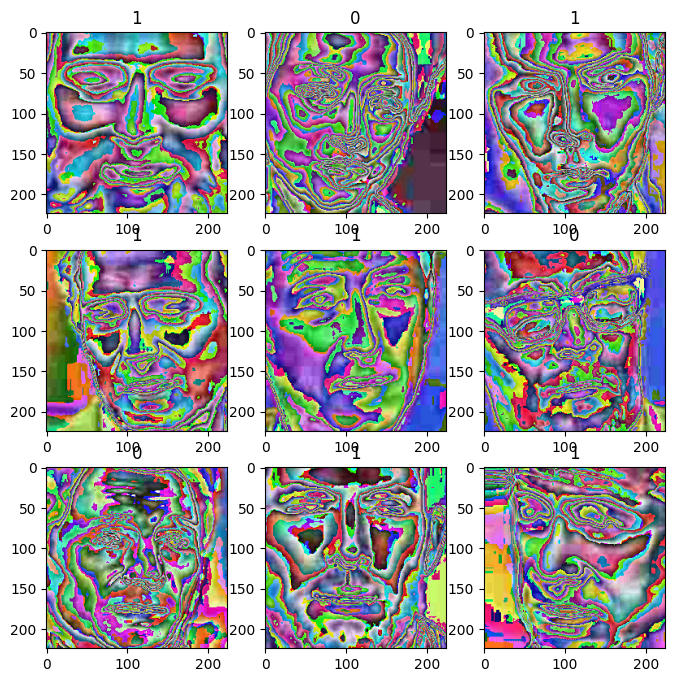

In [14]:
to_img = ToPILImage()

random_idx = np.random.randint(0, len(train_data) - 1, size=9)
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for idx, ax in enumerate(axes.ravel()):
    img = to_img(train_data[random_idx[idx]][0])
    ax.set_title(train_data[random_idx[idx]][1])
    ax.imshow(img)


In [15]:
models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224']
# models = ['xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'swin_base_patch4_window7_224']
# models = ['tf_efficientnet_b7_ns', 'vit_base_patch16_224', 'swin_base_patch4_window7_224']


augs = ['No_Augmentations', 'Random_Cut_Out_Augs', 'Face_Cut_Out_Augs']
datasets = ['CelebDFV2', 'FaceForensics', 'DFDC']

In [17]:
# No augs
for model in models:

    print("==========================================================================")
    print(f"Training {model} on {datasets[0]}")
    print("==========================================================================")
    # print("Training " + model + " on " + datasets[3])
    net = timm.create_model(model, pretrained=True, num_classes=2).to(device)
    epochs = 20
    lr = 1e-3
    # gamma = 0.7

    # loss function
    criterion = nn.CrossEntropyLoss()
    # optimizer - https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
    # https://musstafa0804.medium.com/optimizers-in-deep-learning-7bf81fed78a0
    optimizer = optim.SGD(net.parameters(), lr=lr)
    # scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_accuracies = []
    train_losses = []

    validation_accuracies = []
    validation_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(train_loader):
            data = data.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            output = net(data)
            loss = criterion(output, label)

            loss.backward()
            optimizer.step()
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        train_accuracies.append(epoch_accuracy.detach())
        train_losses.append(epoch_loss.detach())

        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in tqdm(valid_loader):
                data = data.to(device)
                label = label.to(device)
                # print(data.shape)
                val_output = net(data)
                val_loss = criterion(val_output, label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

            validation_accuracies.append(epoch_val_accuracy.detach())
            validation_losses.append(epoch_val_loss.detach())
        
        model_weights = f"Z:/Deepscan-Repository/data/Model_Weights/no_augmentation_testsplit_random_frames/48fps_real_videos/{model}/"
        if not os.path.exists(model_weights):
            os.makedirs(model_weights)

        if epoch == 0:
            PATH = (model_weights + str(epoch+1) + "_epochs.pth")
            torch.save(net.state_dict(), PATH)
        elif epoch > 0:
            if validation_losses[epoch-1] < validation_losses[epoch]:
                pass
            else:
                old_weights_file = (model_weights + str(epoch) + "_epochs.pth")
                if os.path.isfile(old_weights_file):
                    os.remove(old_weights_file)
                else:
                    pass
                # Save the state of the model to file
                PATH = (model_weights + str(epoch+1) + "_epochs.pth")
                torch.save(net.state_dict(), PATH)
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        torch.cuda.empty_cache()


    with open(model_weights + 'results.csv', 'w') as csvfile:
        fieldnames = ['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator='\n',)

        writer.writeheader()
        for i in range(len(validation_accuracies)):
            writer.writerow({'Epoch': i+1, 'Train Accuracy': round(train_accuracies[i].item(), 4), 'Train Loss': round(train_losses[i].item(), 4), 'Validation Accuracy': round(validation_accuracies[i].item(), 4), 'Validation Loss': round(validation_losses[i].item(), 4)})

    print("==========================================================================")
    print("==========================================================================")


Training xception on CelebDFV2


100%|██████████| 998/998 [05:17<00:00,  3.14it/s]


Epoch : 1 - train_loss : 0.4925 - train_acc: 0.7632 - val_loss : 0.4683 - val_acc: 0.7811



100%|██████████| 998/998 [02:13<00:00,  7.47it/s]


Epoch : 2 - train_loss : 0.2908 - train_acc: 0.8831 - val_loss : 0.3516 - val_acc: 0.8513



100%|██████████| 998/998 [02:30<00:00,  6.62it/s]


Epoch : 3 - train_loss : 0.2034 - train_acc: 0.9201 - val_loss : 0.3183 - val_acc: 0.8743



100%|██████████| 998/998 [02:36<00:00,  6.37it/s]


Epoch : 4 - train_loss : 0.1594 - train_acc: 0.9379 - val_loss : 0.2769 - val_acc: 0.8934



100%|██████████| 998/998 [02:33<00:00,  6.52it/s]


Epoch : 5 - train_loss : 0.1303 - train_acc: 0.9488 - val_loss : 0.2814 - val_acc: 0.8947



100%|██████████| 998/998 [02:31<00:00,  6.59it/s]


Epoch : 6 - train_loss : 0.1109 - train_acc: 0.9571 - val_loss : 0.2646 - val_acc: 0.9028



100%|██████████| 998/998 [02:28<00:00,  6.70it/s]


Epoch : 7 - train_loss : 0.0957 - train_acc: 0.9636 - val_loss : 0.2759 - val_acc: 0.9040



100%|██████████| 998/998 [02:37<00:00,  6.34it/s]


Epoch : 8 - train_loss : 0.0823 - train_acc: 0.9688 - val_loss : 0.2650 - val_acc: 0.9122



100%|██████████| 998/998 [02:26<00:00,  6.79it/s]


Epoch : 9 - train_loss : 0.0719 - train_acc: 0.9738 - val_loss : 0.2671 - val_acc: 0.9125



100%|██████████| 998/998 [02:16<00:00,  7.33it/s]


Epoch : 10 - train_loss : 0.0645 - train_acc: 0.9763 - val_loss : 0.2520 - val_acc: 0.9198



100%|██████████| 998/998 [02:17<00:00,  7.26it/s]


Epoch : 11 - train_loss : 0.0570 - train_acc: 0.9793 - val_loss : 0.2447 - val_acc: 0.9231



100%|██████████| 998/998 [02:15<00:00,  7.37it/s]


Epoch : 12 - train_loss : 0.0519 - train_acc: 0.9812 - val_loss : 0.2535 - val_acc: 0.9206



100%|██████████| 998/998 [02:13<00:00,  7.48it/s]


Epoch : 13 - train_loss : 0.0467 - train_acc: 0.9834 - val_loss : 0.2503 - val_acc: 0.9233



100%|██████████| 998/998 [02:20<00:00,  7.12it/s]


Epoch : 14 - train_loss : 0.0413 - train_acc: 0.9854 - val_loss : 0.2644 - val_acc: 0.9238



100%|██████████| 998/998 [02:23<00:00,  6.94it/s]


Epoch : 15 - train_loss : 0.0394 - train_acc: 0.9863 - val_loss : 0.2659 - val_acc: 0.9230



100%|██████████| 998/998 [02:20<00:00,  7.11it/s]


Epoch : 16 - train_loss : 0.0368 - train_acc: 0.9872 - val_loss : 0.2515 - val_acc: 0.9298



100%|██████████| 998/998 [02:18<00:00,  7.21it/s]


Epoch : 17 - train_loss : 0.0332 - train_acc: 0.9888 - val_loss : 0.2625 - val_acc: 0.9287



100%|██████████| 998/998 [02:18<00:00,  7.21it/s]


Epoch : 18 - train_loss : 0.0299 - train_acc: 0.9897 - val_loss : 0.2618 - val_acc: 0.9296



100%|██████████| 998/998 [02:15<00:00,  7.36it/s]


Epoch : 19 - train_loss : 0.0274 - train_acc: 0.9906 - val_loss : 0.2471 - val_acc: 0.9334



100%|██████████| 998/998 [02:29<00:00,  6.66it/s]


Epoch : 20 - train_loss : 0.0255 - train_acc: 0.9915 - val_loss : 0.2467 - val_acc: 0.9335

Training res2net101_26w_4s on CelebDFV2


100%|██████████| 998/998 [04:33<00:00,  3.66it/s]


Epoch : 1 - train_loss : 0.2407 - train_acc: 0.8964 - val_loss : 0.2513 - val_acc: 0.9027



100%|██████████| 998/998 [04:21<00:00,  3.82it/s]


Epoch : 2 - train_loss : 0.0717 - train_acc: 0.9742 - val_loss : 0.2006 - val_acc: 0.9293



100%|██████████| 998/998 [04:22<00:00,  3.81it/s]


Epoch : 3 - train_loss : 0.0396 - train_acc: 0.9867 - val_loss : 0.2104 - val_acc: 0.9324



100%|██████████| 998/998 [04:11<00:00,  3.97it/s]


Epoch : 4 - train_loss : 0.0249 - train_acc: 0.9918 - val_loss : 0.2178 - val_acc: 0.9342



100%|██████████| 998/998 [04:24<00:00,  3.78it/s]


Epoch : 5 - train_loss : 0.0180 - train_acc: 0.9947 - val_loss : 0.1932 - val_acc: 0.9453



100%|██████████| 998/998 [04:09<00:00,  4.00it/s]


Epoch : 6 - train_loss : 0.0124 - train_acc: 0.9962 - val_loss : 0.2043 - val_acc: 0.9425



100%|██████████| 998/998 [04:11<00:00,  3.98it/s]


Epoch : 7 - train_loss : 0.0103 - train_acc: 0.9971 - val_loss : 0.1626 - val_acc: 0.9562



100%|██████████| 998/998 [07:01<00:00,  2.36it/s]


Epoch : 8 - train_loss : 0.0069 - train_acc: 0.9981 - val_loss : 0.1956 - val_acc: 0.9539



100%|██████████| 998/998 [04:17<00:00,  3.88it/s]


Epoch : 9 - train_loss : 0.0056 - train_acc: 0.9985 - val_loss : 0.1822 - val_acc: 0.9543



100%|██████████| 998/998 [04:26<00:00,  3.75it/s]


Epoch : 10 - train_loss : 0.0041 - train_acc: 0.9990 - val_loss : 0.1599 - val_acc: 0.9590



100%|██████████| 998/998 [04:20<00:00,  3.83it/s]


Epoch : 11 - train_loss : 0.0029 - train_acc: 0.9994 - val_loss : 0.1568 - val_acc: 0.9633



100%|██████████| 998/998 [04:22<00:00,  3.80it/s]


Epoch : 12 - train_loss : 0.0022 - train_acc: 0.9995 - val_loss : 0.1967 - val_acc: 0.9570



100%|██████████| 998/998 [04:11<00:00,  3.97it/s]


Epoch : 13 - train_loss : 0.0022 - train_acc: 0.9995 - val_loss : 0.1757 - val_acc: 0.9602



100%|██████████| 998/998 [04:16<00:00,  3.89it/s]


Epoch : 14 - train_loss : 0.0020 - train_acc: 0.9995 - val_loss : 0.1922 - val_acc: 0.9595



100%|██████████| 998/998 [04:14<00:00,  3.92it/s]


Epoch : 15 - train_loss : 0.0019 - train_acc: 0.9995 - val_loss : 0.1669 - val_acc: 0.9640



100%|██████████| 998/998 [06:56<00:00,  2.39it/s]


Epoch : 16 - train_loss : 0.0021 - train_acc: 0.9995 - val_loss : 0.1973 - val_acc: 0.9567



100%|██████████| 998/998 [04:08<00:00,  4.01it/s]


Epoch : 17 - train_loss : 0.0014 - train_acc: 0.9996 - val_loss : 0.1633 - val_acc: 0.9658



100%|██████████| 998/998 [04:13<00:00,  3.93it/s]


Epoch : 18 - train_loss : 0.0018 - train_acc: 0.9994 - val_loss : 0.1707 - val_acc: 0.9635



100%|██████████| 998/998 [04:12<00:00,  3.95it/s]


Epoch : 19 - train_loss : 0.0017 - train_acc: 0.9995 - val_loss : 0.1679 - val_acc: 0.9632



100%|██████████| 998/998 [04:18<00:00,  3.86it/s]
z:\Deepscan-Repository\code\Deepscan\detection_venv\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b7_ns to current tf_efficientnet_b7.ns_jft_in1k.
  model = create_fn(


Epoch : 20 - train_loss : 0.0010 - train_acc: 0.9997 - val_loss : 0.1748 - val_acc: 0.9643

Training tf_efficientnet_b7_ns on CelebDFV2


100%|██████████| 998/998 [04:33<00:00,  3.65it/s]


Epoch : 1 - train_loss : 0.3533 - train_acc: 0.8620 - val_loss : 0.3791 - val_acc: 0.8489



100%|██████████| 998/998 [04:36<00:00,  3.61it/s]


Epoch : 2 - train_loss : 0.1476 - train_acc: 0.9425 - val_loss : 0.2927 - val_acc: 0.8869



100%|██████████| 998/998 [04:36<00:00,  3.61it/s]


Epoch : 3 - train_loss : 0.1008 - train_acc: 0.9610 - val_loss : 0.2626 - val_acc: 0.9031



100%|██████████| 998/998 [04:37<00:00,  3.60it/s]


Epoch : 4 - train_loss : 0.0776 - train_acc: 0.9709 - val_loss : 0.2018 - val_acc: 0.9287



100%|██████████| 998/998 [04:37<00:00,  3.60it/s]


Epoch : 5 - train_loss : 0.0608 - train_acc: 0.9769 - val_loss : 0.2292 - val_acc: 0.9221



100%|██████████| 998/998 [04:40<00:00,  3.56it/s]


Epoch : 6 - train_loss : 0.0516 - train_acc: 0.9809 - val_loss : 0.2212 - val_acc: 0.9272



100%|██████████| 998/998 [04:34<00:00,  3.63it/s]


Epoch : 7 - train_loss : 0.0405 - train_acc: 0.9851 - val_loss : 0.2230 - val_acc: 0.9305



100%|██████████| 998/998 [04:36<00:00,  3.61it/s]


Epoch : 8 - train_loss : 0.0346 - train_acc: 0.9876 - val_loss : 0.2281 - val_acc: 0.9311



100%|██████████| 998/998 [04:40<00:00,  3.56it/s]


Epoch : 9 - train_loss : 0.0306 - train_acc: 0.9888 - val_loss : 0.2194 - val_acc: 0.9351



100%|██████████| 998/998 [04:39<00:00,  3.57it/s]


Epoch : 10 - train_loss : 0.0266 - train_acc: 0.9903 - val_loss : 0.2154 - val_acc: 0.9373



100%|██████████| 998/998 [04:35<00:00,  3.63it/s]


Epoch : 11 - train_loss : 0.0226 - train_acc: 0.9920 - val_loss : 0.2370 - val_acc: 0.9350



100%|██████████| 998/998 [04:34<00:00,  3.63it/s]


Epoch : 12 - train_loss : 0.0195 - train_acc: 0.9931 - val_loss : 0.2180 - val_acc: 0.9407



100%|██████████| 998/998 [07:22<00:00,  2.26it/s]


Epoch : 13 - train_loss : 0.0190 - train_acc: 0.9932 - val_loss : 0.2742 - val_acc: 0.9294



100%|██████████| 998/998 [04:28<00:00,  3.71it/s]


Epoch : 14 - train_loss : 0.0170 - train_acc: 0.9939 - val_loss : 0.2266 - val_acc: 0.9393



100%|██████████| 998/998 [04:37<00:00,  3.60it/s]


Epoch : 15 - train_loss : 0.0145 - train_acc: 0.9946 - val_loss : 0.2377 - val_acc: 0.9372



100%|██████████| 998/998 [04:37<00:00,  3.60it/s]


Epoch : 16 - train_loss : 0.0137 - train_acc: 0.9953 - val_loss : 0.2392 - val_acc: 0.9424



100%|██████████| 998/998 [07:26<00:00,  2.24it/s]


Epoch : 17 - train_loss : 0.0113 - train_acc: 0.9961 - val_loss : 0.2275 - val_acc: 0.9469



100%|██████████| 998/998 [04:28<00:00,  3.72it/s]


Epoch : 18 - train_loss : 0.0106 - train_acc: 0.9965 - val_loss : 0.2656 - val_acc: 0.9377



100%|██████████| 998/998 [04:43<00:00,  3.53it/s]


Epoch : 19 - train_loss : 0.0095 - train_acc: 0.9967 - val_loss : 0.2456 - val_acc: 0.9438



100%|██████████| 998/998 [04:35<00:00,  3.62it/s]


Epoch : 20 - train_loss : 0.0090 - train_acc: 0.9970 - val_loss : 0.2721 - val_acc: 0.9372

Training vit_base_patch16_224 on CelebDFV2


  0%|          | 0/3864 [00:00<?, ?it/s]z:\Deepscan-Repository\code\Deepscan\detection_venv\Lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(
100%|██████████| 998/998 [02:29<00:00,  6.68it/s]


Epoch : 1 - train_loss : 0.1795 - train_acc: 0.9250 - val_loss : 0.1472 - val_acc: 0.9448



100%|██████████| 998/998 [02:27<00:00,  6.78it/s]


Epoch : 2 - train_loss : 0.0343 - train_acc: 0.9879 - val_loss : 0.0994 - val_acc: 0.9678



100%|██████████| 998/998 [02:25<00:00,  6.86it/s]


Epoch : 3 - train_loss : 0.0171 - train_acc: 0.9940 - val_loss : 0.0942 - val_acc: 0.9699



100%|██████████| 998/998 [02:27<00:00,  6.77it/s]


Epoch : 4 - train_loss : 0.0129 - train_acc: 0.9957 - val_loss : 0.0773 - val_acc: 0.9758



100%|██████████| 998/998 [02:30<00:00,  6.62it/s]


Epoch : 5 - train_loss : 0.0063 - train_acc: 0.9979 - val_loss : 0.1397 - val_acc: 0.9642



100%|██████████| 998/998 [02:24<00:00,  6.90it/s]


Epoch : 6 - train_loss : 0.0058 - train_acc: 0.9982 - val_loss : 0.0977 - val_acc: 0.9740



100%|██████████| 998/998 [02:28<00:00,  6.72it/s]


Epoch : 7 - train_loss : 0.0035 - train_acc: 0.9988 - val_loss : 0.1815 - val_acc: 0.9655



100%|██████████| 998/998 [02:29<00:00,  6.68it/s]


Epoch : 8 - train_loss : 0.0037 - train_acc: 0.9987 - val_loss : 0.1534 - val_acc: 0.9675



100%|██████████| 998/998 [02:22<00:00,  6.99it/s]


Epoch : 9 - train_loss : 0.0024 - train_acc: 0.9992 - val_loss : 0.1147 - val_acc: 0.9741



100%|██████████| 998/998 [02:30<00:00,  6.64it/s]


Epoch : 10 - train_loss : 0.0015 - train_acc: 0.9996 - val_loss : 0.1169 - val_acc: 0.9739



100%|██████████| 998/998 [02:31<00:00,  6.58it/s]


Epoch : 11 - train_loss : 0.0018 - train_acc: 0.9994 - val_loss : 0.1414 - val_acc: 0.9701



100%|██████████| 998/998 [02:26<00:00,  6.80it/s]


Epoch : 12 - train_loss : 0.0055 - train_acc: 0.9985 - val_loss : 0.1162 - val_acc: 0.9747



100%|██████████| 998/998 [02:27<00:00,  6.79it/s]


Epoch : 13 - train_loss : 0.0006 - train_acc: 0.9998 - val_loss : 0.1585 - val_acc: 0.9735



100%|██████████| 998/998 [02:26<00:00,  6.83it/s]


Epoch : 14 - train_loss : 0.0005 - train_acc: 0.9999 - val_loss : 0.1294 - val_acc: 0.9774



100%|██████████| 998/998 [02:26<00:00,  6.79it/s]


Epoch : 15 - train_loss : 0.0004 - train_acc: 0.9999 - val_loss : 0.1642 - val_acc: 0.9728



100%|██████████| 998/998 [02:25<00:00,  6.87it/s]


Epoch : 16 - train_loss : 0.0003 - train_acc: 0.9999 - val_loss : 0.1450 - val_acc: 0.9747



100%|██████████| 998/998 [02:45<00:00,  6.03it/s]


Epoch : 17 - train_loss : 0.0003 - train_acc: 0.9999 - val_loss : 0.1570 - val_acc: 0.9737



100%|██████████| 998/998 [02:28<00:00,  6.70it/s]


Epoch : 18 - train_loss : 0.0003 - train_acc: 0.9999 - val_loss : 0.1399 - val_acc: 0.9779



100%|██████████| 998/998 [02:59<00:00,  5.56it/s]


Epoch : 19 - train_loss : 0.0003 - train_acc: 0.9999 - val_loss : 0.1431 - val_acc: 0.9758



100%|██████████| 998/998 [02:26<00:00,  6.81it/s]


Epoch : 20 - train_loss : 0.0002 - train_acc: 0.9999 - val_loss : 0.1508 - val_acc: 0.9760

Training swin_base_patch4_window7_224 on CelebDFV2


100%|██████████| 998/998 [04:35<00:00,  3.63it/s]


Epoch : 1 - train_loss : 0.3052 - train_acc: 0.8661 - val_loss : 0.1835 - val_acc: 0.9270



100%|██████████| 998/998 [04:33<00:00,  3.64it/s]


Epoch : 2 - train_loss : 0.1074 - train_acc: 0.9586 - val_loss : 0.2239 - val_acc: 0.9165



100%|██████████| 998/998 [07:04<00:00,  2.35it/s]


Epoch : 3 - train_loss : 0.0666 - train_acc: 0.9749 - val_loss : 0.1351 - val_acc: 0.9532



100%|██████████| 998/998 [04:03<00:00,  4.09it/s]


Epoch : 4 - train_loss : 0.0561 - train_acc: 0.9792 - val_loss : 0.1076 - val_acc: 0.9622



100%|██████████| 998/998 [03:59<00:00,  4.16it/s]


Epoch : 5 - train_loss : 0.0395 - train_acc: 0.9855 - val_loss : 0.0918 - val_acc: 0.9656



100%|██████████| 998/998 [03:56<00:00,  4.21it/s]


Epoch : 6 - train_loss : 0.0391 - train_acc: 0.9861 - val_loss : 0.2069 - val_acc: 0.9368



100%|██████████| 998/998 [03:54<00:00,  4.26it/s]


Epoch : 7 - train_loss : 0.0287 - train_acc: 0.9897 - val_loss : 0.0863 - val_acc: 0.9716



100%|██████████| 998/998 [03:48<00:00,  4.36it/s]


Epoch : 8 - train_loss : 0.0239 - train_acc: 0.9915 - val_loss : 0.3440 - val_acc: 0.9076



100%|██████████| 998/998 [03:53<00:00,  4.27it/s]


Epoch : 9 - train_loss : 0.0226 - train_acc: 0.9921 - val_loss : 0.0846 - val_acc: 0.9716



100%|██████████| 998/998 [03:53<00:00,  4.27it/s]


Epoch : 10 - train_loss : 0.0174 - train_acc: 0.9938 - val_loss : 0.0817 - val_acc: 0.9760



100%|██████████| 998/998 [03:53<00:00,  4.27it/s]


Epoch : 11 - train_loss : 0.0154 - train_acc: 0.9947 - val_loss : 0.1100 - val_acc: 0.9695



100%|██████████| 998/998 [06:20<00:00,  2.63it/s]


Epoch : 12 - train_loss : 0.0131 - train_acc: 0.9955 - val_loss : 0.0781 - val_acc: 0.9782



100%|██████████| 998/998 [03:51<00:00,  4.32it/s]


Epoch : 13 - train_loss : 0.0110 - train_acc: 0.9962 - val_loss : 0.1077 - val_acc: 0.9733



100%|██████████| 998/998 [11:04<00:00,  1.50it/s]


Epoch : 14 - train_loss : 0.0109 - train_acc: 0.9964 - val_loss : 0.0809 - val_acc: 0.9762



100%|██████████| 998/998 [06:28<00:00,  2.57it/s]


Epoch : 15 - train_loss : 0.0114 - train_acc: 0.9961 - val_loss : 0.0832 - val_acc: 0.9753



 89%|████████▉ | 3453/3864 [20:12<02:40,  2.56it/s]

: 

## Model Evaluation

In [ ]:
# model_weights = f"E:/Deepscan-Repository/data/Model_Weights/no_augmentation_testsplit_random_frames/subset_400_vids/{model}/"
# eval_dir = f'{model_weights}model_evaluation'
for i in range(15):
    np.random.shuffle(test_images)

# for model in models:

#     frame = pd.DataFrame(test_images, columns=['path'])
#     # Add the new 'label' column
#     frame['label'] = frame['path'].apply(lambda x: 0 if 'real' in x else 1)
#     frame.to_csv(f'{eval_dir}/celebdf_v2_test_images.csv', index=False, sep=',', header=True, encoding='utf-8')

#     celebdf_test_csv = pd.read_csv(f"{eval_dir}/celebdf_v2_test_images.csv")

In [ ]:
# PATH = "E:/rclone/weights/supervised_models/swin_base_patch4_window7_224/no_augmentation/celebdf_v2"
# PATH = "Z:/Deepscan-Repository/weights/no_augmentation_testsplit_random_frames/celebdf_v2/48_real_frames/"
# model_name = "swin_base_patch4_window7_224"

for saved_model in models:
    PATH = f"Z:/Deepscan-Repository/data/Model_Weights/no_augmentation_testsplit_random_frames/48fps_real_videos/{saved_model}/"
    # model_weights = f"E:/Deepscan-Repository/data/Model_Weights/no_augmentation_testsplit_random_frames/subset_400_vids/{model}/"

    frame = pd.DataFrame(test_images, columns=['path'])
    # Add the new 'label' column
    frame['label'] = frame['path'].apply(lambda x: 0 if 'real' in x else 1)
    frame.to_csv(f'{PATH}/celebdf_v2_test_images.csv', index=False, sep=',', header=True, encoding='utf-8')

    celebdf_test_csv = pd.read_csv(f"{PATH}/celebdf_v2_test_images.csv")

    for file in os.listdir(PATH):
        if file.endswith(".pth"):
            model_path = os.path.join(PATH, file)
            model = timm.create_model(saved_model, pretrained=True, num_classes=2).to(device)
            model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

            print(f'+++++++++++++Evaluating {saved_model} trained on CelebDF-v2+++++++++++++')
            print(f"+++++++++++++Loaded {file} weights!+++++++++++++")

            # Create the save path
            # save_dir = os.path.join(f"{PATH}/{file}")
            # if not os.path.exists(save_dir):
            #     os.makedirs(save_dir)

            save_path = os.path.join(PATH, f"{os.path.splitext(file)[0]}_pth_result.csv")

            # torch.manual_seed(42)
            Evaluate(model, celebdf_test_csv, save_path)

            print('====================================================================================================\n\n')

e:\Deepscan-Repository\code\Deepscan\deepfake_venv\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


+++++++++++++Evaluating xception trained on CelebDF-v2+++++++++++++
+++++++++++++Loaded 10_epochs.pth weights!+++++++++++++


Processing images: 100%|██████████| 60/60 [00:58<00:00,  1.02batch/s]


+-----------+-------------+---------+------------+
|   Logloss |   AUC Score |      F1 |   Accuracy |
+===========+=============+=========+============+
|  0.830595 |    0.460232 | 0.59204 |   0.654008 |
+-----------+-------------+---------+------------+


+++++++++++++Evaluating res2net101_26w_4s trained on CelebDF-v2+++++++++++++
+++++++++++++Loaded 10_epochs.pth weights!+++++++++++++


Processing images: 100%|██████████| 60/60 [01:13<00:00,  1.22s/batch]


+-----------+-------------+----------+------------+
|   Logloss |   AUC Score |       F1 |   Accuracy |
+===========+=============+==========+============+
|  0.979069 |    0.654262 | 0.725359 |   0.697257 |
+-----------+-------------+----------+------------+


+++++++++++++Evaluating res2net101_26w_4s trained on CelebDF-v2+++++++++++++
+++++++++++++Loaded 5_epochs.pth weights!+++++++++++++


Processing images: 100%|██████████| 60/60 [01:14<00:00,  1.24s/batch]


+-----------+-------------+----------+------------+
|   Logloss |   AUC Score |       F1 |   Accuracy |
+===========+=============+==========+============+
|  0.724823 |    0.641233 | 0.663121 |   0.599156 |
+-----------+-------------+----------+------------+


+++++++++++++Evaluating res2net101_26w_4s trained on CelebDF-v2+++++++++++++
+++++++++++++Loaded 8_epochs.pth weights!+++++++++++++


Processing images: 100%|██████████| 60/60 [01:11<00:00,  1.19s/batch]
e:\Deepscan-Repository\code\Deepscan\deepfake_venv\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b7_ns to current tf_efficientnet_b7.ns_jft_in1k.
  model = create_fn(


+-----------+-------------+----------+------------+
|   Logloss |   AUC Score |       F1 |   Accuracy |
+===========+=============+==========+============+
|  0.815733 |    0.656803 | 0.697472 |   0.633966 |
+-----------+-------------+----------+------------+


+++++++++++++Evaluating tf_efficientnet_b7_ns trained on CelebDF-v2+++++++++++++
+++++++++++++Loaded 10_epochs.pth weights!+++++++++++++


Processing images: 100%|██████████| 60/60 [02:24<00:00,  2.40s/batch]
e:\Deepscan-Repository\code\Deepscan\deepfake_venv\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b7_ns to current tf_efficientnet_b7.ns_jft_in1k.
  model = create_fn(


+-----------+-------------+----------+------------+
|   Logloss |   AUC Score |       F1 |   Accuracy |
+===========+=============+==========+============+
|   1.37015 |     0.49256 | 0.621622 |    0.64557 |
+-----------+-------------+----------+------------+


+++++++++++++Evaluating tf_efficientnet_b7_ns trained on CelebDF-v2+++++++++++++
+++++++++++++Loaded 6_epochs.pth weights!+++++++++++++


Processing images: 100%|██████████| 60/60 [02:23<00:00,  2.39s/batch]

+-----------+-------------+----------+------------+
|   Logloss |   AUC Score |       F1 |   Accuracy |
+===========+=============+==========+============+
|   1.16521 |    0.529281 | 0.626804 |   0.618143 |
+-----------+-------------+----------+------------+




In [ ]:
def get_scores(predictions):
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for key, value in predictions.items():
        predicted_probs.append(value[0])
        predicted_labels.append(value[1])
        true_labels.append(value[2])

    logloss = log_loss(true_labels, predicted_probs)
    auc = roc_auc_score(true_labels, predicted_probs)
    f1 = f1_score(true_labels, predicted_labels)
    acc = accuracy_score(true_labels, predicted_labels)
        
    print(tabulate([[logloss, auc, f1, acc]], headers=['Logloss', 'AUC Score', 'F1', 'Accuracy'], tablefmt="grid"))
    return logloss, auc, f1, acc

def Evaluate(model, faces_path_dict, save_path, batch_size=16):
        
    labels_map = ['real', 'fake']
    predictions = {}
    faces = []

    # Preprocess the faces
    for img in faces_path_dict['path']:
        if img.endswith('.jpg'):
            face = cv2.imread(img)
            faces.append(face)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Create batches of preprocessed face tensors
    face_tensors = [transform(Image.fromarray(face)).unsqueeze(0).to(device) for face in faces]
    batches = [face_tensors[i:i+batch_size] for i in range(0, len(face_tensors), batch_size)]

    # Run the model on the batches
    model.eval()
    with torch.no_grad():
        for batch in tqdm(batches, desc="Processing images", unit="batch"):
            outputs = model(torch.cat(batch, dim=0))
            batch_probability_fake = torch.softmax(outputs, 1)[:, 1].tolist()
            batch_probability_real = torch.softmax(outputs, 1)[:, 0].tolist()

            for i, img in enumerate(faces_path_dict['path'][len(predictions):len(predictions)+len(batch)]):
                original_label = 0 if 'real' in img else 1
                if labels_map[torch.argmax(outputs[i]).item()] == 'fake':
                    predictions[img] = [batch_probability_fake[i], 1, original_label]
                else:
                    predictions[img] = [batch_probability_real[i], 0, original_label]

    with open(save_path, "w", newline="") as csvfile:
        fieldnames = ["ImagePath", "ProbabilityScore", "PredictedLabel", "OriginalLabel"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator="\n")
        writer.writeheader()
        for img, prediction in predictions.items():
            writer.writerow(
                {
                    "ImagePath": img,
                    "ProbabilityScore": prediction[0],
                    "PredictedLabel": prediction[1],
                    "OriginalLabel": prediction[2],
                }
            )

    logloss, auc, f1, acc = get_scores(predictions)
    with open(save_path, "a", newline="") as csvfile:
        fieldnames = ["LogLoss", "AUC", "F1-Score", "Accuracy"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, lineterminator="\n")
        writer.writeheader()
        writer.writerow({"LogLoss": logloss, "AUC": auc, "F1-Score": f1, "Accuracy": acc})

    torch.cuda.empty_cache()